<a href="https://colab.research.google.com/github/bekku/deeplearning/blob/master/on_the_Efficacy_of_Knowledge_Distillation%E5%AE%9F%E9%A8%93(%E4%BF%9D%E5%AD%98%E7%89%88).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Dec  4 03:13:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    22W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn.functional as f
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
import random
# !pip install deap
# from deap import base, creator, tools
import pandas as pd
!pip install Gpyopt
import GPyOpt
!pip install torch-summary
from torchsummary import summary


from google.colab import drive #インポート
drive.mount('/content/gdrive') #GoogleDriveのマウント
def load_cifar10(batch=128):
    train_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                # (0.4914,0.4822,0.4465),(0.247,0.243,0.261)
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                # (0.4914,0.4822,0.4465),(0.247,0.243,0.261)
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
    )

    return {'train': train_loader, 'test': test_loader}

torch.cuda.is_available()
loader = load_cifar10()

     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 1.0MB 9.7MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
  Created wheel for Gpyopt: filename=GPyOpt-1.2.6-cp36-none-any.whl size=83622 sha256=f45f82c59ea87739267d1162c4e5db82d921262ce2213fbc2b07a6e0ec19e6a7
  Stored in directory: /root/.cache/pip/wheels/b2/00/69/cfa967a125cf25e66f644be6193ad6f0edf231147879ad714f
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633951 sha256=1729accdea4ce096016aeca8b459fe7f7bb8da91da9f2e1dd49b5a88bab20c39
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=02f9dcce8c5f7200d491469e6eb0e1c2f53aff2dec98785459eb5deabdf9805b
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built Gpyopt GPy paramz
Mounted at /content

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# **VGG16**

In [ ]:
class VGG16(nn.Module):
    def __init__(self): # , num_classes):
        super(VGG16, self).__init__()
        num_classes=10

        self.block1_output = nn.Sequential (
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block2_output = nn.Sequential (
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block3_output = nn.Sequential (
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block4_output = nn.Sequential (
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.block5_output = nn.Sequential (
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),  #512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 32 ),  #4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(32, num_classes),  #4096
        )

    def forward(self, x,T=1):
        x = self.block1_output(x)
        # print(x.size())
        x = self.block2_output(x)
        # print(x.size())
        x = self.block3_output(x)
        # print(x.size())
        x = self.block4_output(x)
        # print(x.size())
        x = self.block5_output(x)
        # print(x.size())
        x = x.view(x.size(0), -1)
        # print(x.size())
        x = self.classifier(x)
        x = x/T
        return f.softmax(x,dim=-1)
VGG16

__main__.VGG16

# **VGG16-大中小モデル生成**

In [ ]:
class CreateVGG_2(torch.nn.Module):
    def __init__(self, VGG_model_list):
        super(CreateVGG_2, self).__init__()
        self.count = 0

        PRE_FILTER = 3
        for i in range(len(VGG_model_list)):
            if VGG_model_list[i]!=0:
                FILTER = VGG_model_list[i]
                self._modules["fc"+str(i+1)] = nn.Sequential (
                nn.Conv2d(PRE_FILTER, FILTER, kernel_size=3, padding=1),
                nn.BatchNorm2d(FILTER),
                nn.ReLU(inplace=True),
                )
                PRE_FILTER=FILTER

        self.classifier = nn.Sequential(
            nn.Linear(PRE_FILTER, PRE_FILTER), 
            nn.ReLU(True),
            nn.Linear(PRE_FILTER, PRE_FILTER//2 ), 
            nn.ReLU(True),
            nn.Linear(PRE_FILTER//2, 10), 
        )
        self.pool = torch.nn.MaxPool2d(2, 2) 
        

    def forward(self, x, T=1):
        for i in range(1,14):
            if "fc"+str(i) in self._modules:
                x = f.relu(self._modules["fc"+str(i)](x))
            if i==2 or i==4 or i==7 or i==10 or i==13:
                x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        # x = x/T
        # return f.log_softmax(x,dim=1)
        return x

## **VGG学習**

In [ ]:
mini_model = [1, 3, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1]

In [ ]:
midle_model = [2, 2, 0, 0, 0, 1, 1, 0, 4, 5, 0, 0, 0, 3]

In [ ]:
large_model = [2, 0, 2, 3, 0, 4, 4, 0, 6, 3, 3, 0, 0, 6]

In [ ]:
def hard_target_learning(gane,epoch):
    # 入力された乗数から、本当のモデルのノード数とする。
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    gane=list(map(int,gane))
    print(*gane)
    model_gane=[]
    gane_number=[0,16,32,64,128,256,512]
    for i in gane:
        if gane_number[i]!=0:
            model_gane.append(gane_number[i])

    net: torch.nn.Module = CreateVGG_2(model_gane)
    net.to(device)
    criterion = torch.nn.CrossEntropyLoss() 
    # optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9, weight_decay = 0.008)

    global history_mini
    history_mini = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    lr_set = 0.1
    for e in range(epoch):
        if e!=0 and e%60==0:
            lr_set *= 0.2
        optimizer = torch.optim.SGD(net.parameters(), lr=lr_set,momentum=0.9, weight_decay=5e-4)

        # if e%100==0 and e!=0:
        #     optimizer = torch.optim.SGD(net.parameters(), lr=0.01/(e/10),momentum=0.9, weight_decay=5e-4)
        net.train()
        loss = None
        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device) 
            labels = labels.to(device)

            optimizer.zero_grad()
            output = net(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        history_mini['train_loss'].append(loss.item())
        print('Training log: {} epoch：Loss: {}'.format(e + 1,loss.item()))
      
        net.eval()

        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(loader['test']):
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        acc = float(correct / (10000))
        print('test accuracy:{}'.format(acc))
        history_mini['test_acc'].append(acc)
        
    #====== 保存 =======
    path = "/content/gdrive/My Drive/2020_秋_TERM/2020_12_初月/VGG_mini.pth" # 保存先pathの設定
    torch.save(net.state_dict(), path)

    # 結果をプロット
    plt.figure()
    plt.plot(range(1, epoch+1), history_mini['train_loss'])
    plt.title('Training Loss [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('cifar10_loss.png')
    
    
    plt.figure()
    plt.plot(range(1, epoch + 1), history_mini['test_acc'], label='test_acc')
    plt.title('Accuracies [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('cifar10_acc.png')

1 3 2 0 0 0 0 0 3 0 0 0 0 1
Training log: 1 epoch：Loss: 1.6422197818756104
test accuracy:0.3963
Training log: 2 epoch：Loss: 1.2544615268707275
test accuracy:0.4335
Training log: 3 epoch：Loss: 1.0054025650024414
test accuracy:0.5477
Training log: 4 epoch：Loss: 0.8449075818061829
test accuracy:0.573
Training log: 5 epoch：Loss: 0.8791260719299316
test accuracy:0.6159
Training log: 6 epoch：Loss: 0.8229416608810425
test accuracy:0.5418
Training log: 7 epoch：Loss: 0.8994213938713074
test accuracy:0.6474
Training log: 8 epoch：Loss: 0.8634784817695618
test accuracy:0.599
Training log: 9 epoch：Loss: 0.8417493104934692
test accuracy:0.5549
Training log: 10 epoch：Loss: 1.0011924505233765
test accuracy:0.6234
Training log: 11 epoch：Loss: 0.7012103796005249
test accuracy:0.6378
Training log: 12 epoch：Loss: 0.9397631883621216
test accuracy:0.676
Training log: 13 epoch：Loss: 0.8894190788269043
test accuracy:0.6968
Training log: 14 epoch：Loss: 0.6626571416854858
test accuracy:0.6049
Training log: 15 e

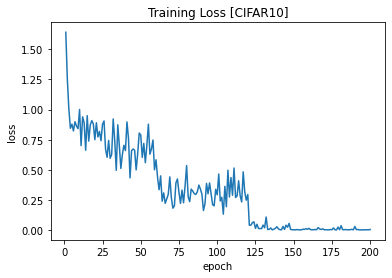

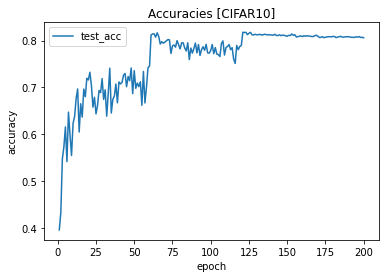

In [ ]:
hard_target_learning(mini_model,200)
# history_mini

In [ ]:
def hard_target_learning(gane,epoch):
    # 入力された乗数から、本当のモデルのノード数とする。
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    gane=list(map(int,gane))
    print(*gane)
    model_gane=[]
    gane_number=[0,16,32,64,128,256,512]
    for i in gane:
        if gane_number[i]!=0:
            model_gane.append(gane_number[i])

    net: torch.nn.Module = CreateVGG_2(model_gane)
    net.to(device)
    criterion = torch.nn.CrossEntropyLoss() 
    # optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9, weight_decay = 0.008)
    global history_midle
    history_midle = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    lr_set = 0.1
    for e in range(epoch):
        if e!=0 and e%60==0:
            lr_set *= 0.2
        optimizer = torch.optim.SGD(net.parameters(), lr=lr_set,momentum=0.9, weight_decay=5e-4)

        # if e%100==0 and e!=0:
        #     optimizer = torch.optim.SGD(net.parameters(), lr=0.01/(e/10),momentum=0.9, weight_decay=5e-4)
        net.train()
        loss = None
        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device) 
            labels = labels.to(device)

            optimizer.zero_grad()
            output = net(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        history_midle['train_loss'].append(loss.item())
        print('Training log: {} epoch：Loss: {}'.format(e + 1,loss.item()))
      
        net.eval()

        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(loader['test']):
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        acc = float(correct / (10000))
        print('test accuracy:{}'.format(acc))
        history_midle['test_acc'].append(acc)
        
    #====== 保存 =======
    path = "/content/gdrive/My Drive/2020_秋_TERM/2020_12_初月/VGG_midle.pth" # 保存先pathの設定
    torch.save(net.state_dict(), path)

    # 結果をプロット
    plt.figure()
    plt.plot(range(1, epoch+1), history_midle['train_loss'])
    plt.title('Training Loss [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('cifar10_loss.png')
    
    
    plt.figure()
    plt.plot(range(1, epoch + 1), history_midle['test_acc'], label='test_acc')
    plt.title('Accuracies [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('cifar10_acc.png')

2 2 0 0 0 1 1 0 4 5 0 0 0 3
Training log: 1 epoch：Loss: 1.2818862199783325
test accuracy:0.48
Training log: 2 epoch：Loss: 0.9841036796569824
test accuracy:0.6071
Training log: 3 epoch：Loss: 0.801956295967102
test accuracy:0.6828
Training log: 4 epoch：Loss: 1.0944699048995972
test accuracy:0.7135
Training log: 5 epoch：Loss: 0.7842499017715454
test accuracy:0.7198
Training log: 6 epoch：Loss: 0.5097271800041199
test accuracy:0.6819
Training log: 7 epoch：Loss: 0.6212907433509827
test accuracy:0.7079
Training log: 8 epoch：Loss: 0.5193194150924683
test accuracy:0.7275
Training log: 9 epoch：Loss: 0.7492774724960327
test accuracy:0.724
Training log: 10 epoch：Loss: 0.7962929606437683
test accuracy:0.6858
Training log: 11 epoch：Loss: 0.5975402593612671
test accuracy:0.7627
Training log: 12 epoch：Loss: 0.5288028717041016
test accuracy:0.7673
Training log: 13 epoch：Loss: 0.43853458762168884
test accuracy:0.7173
Training log: 14 epoch：Loss: 0.4636630117893219
test accuracy:0.719
Training log: 15 ep

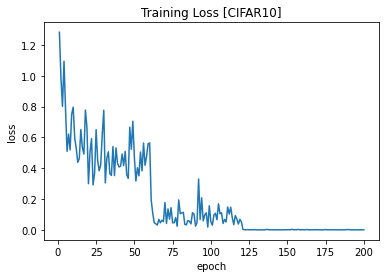

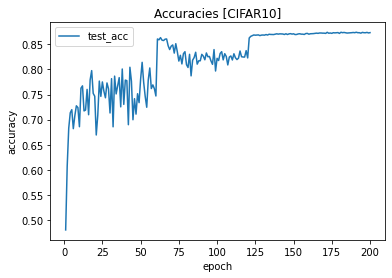

In [ ]:
hard_target_learning(midle_model,200)
# history_midle

In [ ]:
def hard_target_learning(gane,epoch):
    # 入力された乗数から、本当のモデルのノード数とする。
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    gane=list(map(int,gane))
    print(*gane)
    model_gane=[]
    gane_number=[0,16,32,64,128,256,512]
    for i in gane:
        if gane_number[i]!=0:
            model_gane.append(gane_number[i])

    net: torch.nn.Module = CreateVGG_2(model_gane)
    net.to(device)
    criterion = torch.nn.CrossEntropyLoss() 
    # optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9, weight_decay = 0.008)
    global history_large
    history_large = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    lr_set = 0.1
    for e in range(epoch):
        if e!=0 and e%60==0:
            lr_set *= 0.2
        optimizer = torch.optim.SGD(net.parameters(), lr=lr_set,momentum=0.9, weight_decay=5e-4)

        # if e%100==0 and e!=0:
        #     optimizer = torch.optim.SGD(net.parameters(), lr=0.01/(e/10),momentum=0.9, weight_decay=5e-4)
        net.train()
        loss = None
        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device) 
            labels = labels.to(device)

            optimizer.zero_grad()
            output = net(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        history_large['train_loss'].append(loss.item())
        print('Training log: {} epoch：Loss: {}'.format(e + 1,loss.item()))
      
        net.eval()

        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(loader['test']):
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        acc = float(correct / (10000))
        print('test accuracy:{}'.format(acc))
        history_large['test_acc'].append(acc)
        
    #====== 保存 =======
    path = "/content/gdrive/My Drive/2020_秋_TERM/2020_12_初月/VGG_large.pth" # 保存先pathの設定
    torch.save(net.state_dict(), path)

    # 結果をプロット
    plt.figure()
    plt.plot(range(1, epoch+1), history_large['train_loss'])
    plt.title('Training Loss [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('cifar10_loss.png')
    
    
    plt.figure()
    plt.plot(range(1, epoch + 1), history_large['test_acc'], label='test_acc')
    plt.title('Accuracies [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('cifar10_acc.png')

2 0 2 3 0 4 4 0 6 3 3 0 0 6
Training log: 1 epoch：Loss: 1.2438691854476929
test accuracy:0.489
Training log: 2 epoch：Loss: 0.775840699672699
test accuracy:0.4828
Training log: 3 epoch：Loss: 0.868427574634552
test accuracy:0.6395
Training log: 4 epoch：Loss: 0.6925153136253357
test accuracy:0.7033
Training log: 5 epoch：Loss: 0.35735708475112915
test accuracy:0.7005
Training log: 6 epoch：Loss: 0.5551917552947998
test accuracy:0.7437
Training log: 7 epoch：Loss: 0.4671506881713867
test accuracy:0.7912
Training log: 8 epoch：Loss: 0.4675062298774719
test accuracy:0.7431
Training log: 9 epoch：Loss: 0.5420308709144592
test accuracy:0.7805
Training log: 10 epoch：Loss: 0.2675414979457855
test accuracy:0.7372
Training log: 11 epoch：Loss: 0.45052391290664673
test accuracy:0.7353
Training log: 12 epoch：Loss: 0.5173389315605164
test accuracy:0.7252
Training log: 13 epoch：Loss: 0.3149004578590393
test accuracy:0.781
Training log: 14 epoch：Loss: 0.32423633337020874
test accuracy:0.789
Training log: 15 

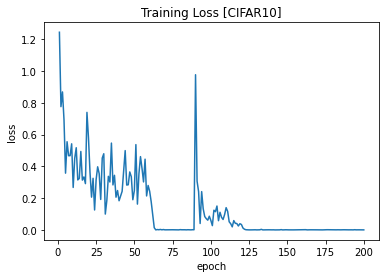

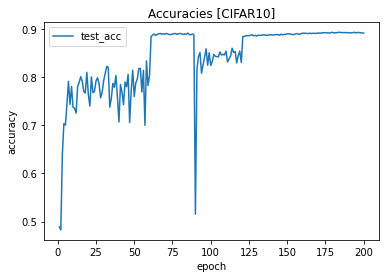

In [ ]:
hard_target_learning(large_model,200)
# history_large

In [ ]:
def gane_convert(gane):
    gane=list(map(int,gane))
    print(gane)
    model_gane=[]
    gane_number=[0,16,32,64,128,256,512]
    for i in gane:
        if gane_number[i]!=0:
            model_gane.append(gane_number[i])
    print(model_gane)
    return model_gane

### **大中小モデル**

In [ ]:
mini_net: torch.nn.Module = CreateVGG_2(gane_convert(mini_model))
param = torch.load('/content/gdrive/My Drive/2020_秋_TERM/2020_12_初月/VGG_mini.pth')
mini_net.load_state_dict(param)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mini_net.to(device)

midle_net: torch.nn.Module = CreateVGG_2(gane_convert(midle_model))
param = torch.load('/content/gdrive/My Drive/2020_秋_TERM/2020_12_初月/VGG_midle.pth')
midle_net.load_state_dict(param)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
midle_net.to(device)

large_net: torch.nn.Module = CreateVGG_2(gane_convert(large_model))
param = torch.load("/content/gdrive/My Drive/2020_秋_TERM/2020_12_初月/VGG_large.pth")
large_net.load_state_dict(param)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
large_net.to(device)

[1, 3, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1]
[16, 64, 32, 64, 16]
[2, 2, 0, 0, 0, 1, 1, 0, 4, 5, 0, 0, 0, 3]
[32, 32, 16, 16, 128, 256, 64]
[2, 0, 2, 3, 0, 4, 4, 0, 6, 3, 3, 0, 0, 6]
[32, 32, 64, 128, 128, 512, 64, 64, 512]


CreateVGG_2(
  (fc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc5): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d

Loss = Lcls + LKD

ロス関数

In [ ]:
def knowldge_distillation(T_net,gane,epoch):
    # 入力された乗数から、本当のモデルのノード数とする。
    gane=list(map(int,gane))
    print(*gane)
    model_gane=[]
    gane_number=[0,16,32,64,128,256,512]
    for i in gane:
        if gane_number[i]!=0:
            model_gane.append(gane_number[i])
    global history_large_to_mini
    history_large_to_mini = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    net: torch.nn.Module = CreateVGG_2(model_gane)
    net.to(device)
    T_net.to(device)

    criterion = T_S_Closs_entropy()
    
    lr_set = 0.1
    for e in range(epoch):
        if e!=0 and e%60==0:
            lr_set *= 0.2
        optimizer = torch.optim.SGD(net.parameters(), lr=lr_set,momentum=0.9, weight_decay=5e-4)
        net.train()
        loss = None

        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device) 
            labels = labels.to(device)

            optimizer.zero_grad()
            output = net(images)
            data_one = T_net(images)

            #(p, q, label, T)
            loss = criterion(output, data_one, labels, 4)
            loss.backward()
            optimizer.step()
        history_large_to_mini['train_loss'].append(loss.item())
        print('Training log: {} epoch：Loss: {}'.format(e + 1,loss.item()))

        net.eval()
        correct = 0
        with torch.no_grad():
            for images, labels in loader['test']:
                images = images.to(device) 
                labels = labels.to(device)
                #　蒸留モデルは、推論時は温度を1に戻します。
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                #torch.max(a, axis) (axis=0:col, axis=1:row)ごとに最大値を取ってくれている。
                correct += (predicted == labels).sum().item()

        acc = float(correct / (10000))
        print('test accuracy:{}'.format(acc))
        history_large_to_mini['test_acc'].append(acc)

    path = "/content/gdrive/My Drive/2020_秋_TERM/2020_12_初月/large_to_mini.pth" # 保存先pathの設定
    torch.save(net.state_dict(), path)

     # 結果をプロット
    plt.figure()
    plt.plot(range(1, epoch+1), history_large_to_mini['train_loss'])
    plt.title('Training Loss [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('cifar10_loss.png')
    
    
    plt.figure()
    plt.plot(range(1, epoch + 1), history_large_to_mini['test_acc'], label='test_acc')
    plt.title('Accuracies [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('cifar10_acc.png')

    # accとelapsedは、教師モデルの出力を受け取るようにしておきましょう。
    # return speed_acc_normalization_harmonic_mean(s_max,0,elapsed_time,a_max,0,acc)

In [ ]:
# class T_S_Closs_entropy(torch.nn.Module):
#     def __init__(self):
#         super(T_S_Closs_entropy, self).__init__()

#     def forward(self, q, p, label, T):
#         #pが教師モデル、qが生徒モデルの出力値(既に対数化してます)。
#         # print(p,q)
#         p = p/T
#         q = q/T
#         # qのみlogの中に入ります。
#         q = f.log_softmax(q,dim=1)
#         p = f.softmax(p,dim=1)
#         loss = torch.mul(p,q)
#         loss = -torch.sum(loss)
#         loss = loss/len(p)
#         loss = loss * T * T
#         # print(loss)
#         return loss

In [ ]:
class T_S_Closs_entropy(torch.nn.Module):
    def __init__(self):
        super(T_S_Closs_entropy, self).__init__()
        self.criterion = torch.nn.CrossEntropyLoss() 

    def forward(self, q, p, label, T, a=0.9):
        #教師モデルをp、生徒モデルq、正解ラベル、温度が引数となる
        loss = self.criterion(q,label)

        p = p/T
        q = q/T
        # qのみlogの中に入ります。
        q = f.log_softmax(q,dim=1)
        p = f.softmax(p,dim=1)
        loss_LKD = torch.mul(p,q)
        loss_LKD = -torch.sum(loss_LKD)
        loss_LKD = loss_LKD/len(p)
        loss_LKD = loss_LKD * T * T

        loss = a*loss
        loss_LKD = (1-a)*loss_LKD

        loss = loss + loss_LKD
        return loss

1 3 2 0 0 0 0 0 3 0 0 0 0 1
Training log: 1 epoch：Loss: 4.5405144691467285
test accuracy:0.3731
Training log: 2 epoch：Loss: 4.346406936645508
test accuracy:0.4021
Training log: 3 epoch：Loss: 3.9869117736816406
test accuracy:0.4308
Training log: 4 epoch：Loss: 4.155825614929199
test accuracy:0.5485
Training log: 5 epoch：Loss: 3.8512637615203857
test accuracy:0.5388
Training log: 6 epoch：Loss: 3.5802383422851562
test accuracy:0.6309
Training log: 7 epoch：Loss: 4.003159999847412
test accuracy:0.6407
Training log: 8 epoch：Loss: 3.656604290008545
test accuracy:0.6583
Training log: 9 epoch：Loss: 3.4612669944763184
test accuracy:0.6362
Training log: 10 epoch：Loss: 3.622408628463745
test accuracy:0.6408
Training log: 11 epoch：Loss: 3.2375097274780273
test accuracy:0.6707
Training log: 12 epoch：Loss: 3.8303394317626953
test accuracy:0.6215
Training log: 13 epoch：Loss: 3.5771443843841553
test accuracy:0.6327
Training log: 14 epoch：Loss: 3.5978753566741943
test accuracy:0.6773
Training log: 15 epo

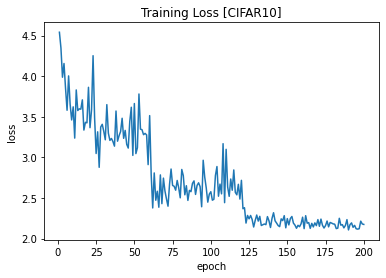

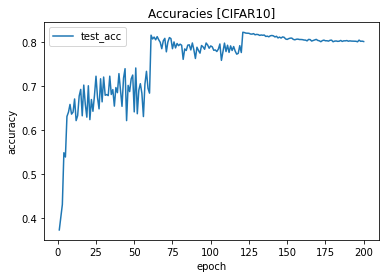

In [ ]:
knowldge_distillation(large_net,mini_model,200)
# history_large_to_mini

In [ ]:
def knowldge_distillation(T_net,gane,epoch):
    # 入力された乗数から、本当のモデルのノード数とする。
    gane=list(map(int,gane))
    print(*gane)
    model_gane=[]
    gane_number=[0,16,32,64,128,256,512]
    for i in gane:
        if gane_number[i]!=0:
            model_gane.append(gane_number[i])
    global history_midle_to_mini
    history_midle_to_mini = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    net: torch.nn.Module = CreateVGG_2(model_gane)
    net.to(device)
    T_net.to(device)

    criterion = T_S_Closs_entropy()
    
    lr_set = 0.1
    for e in range(epoch):
        if e!=0 and e%60==0:
            lr_set *= 0.2
        optimizer = torch.optim.SGD(net.parameters(), lr=lr_set,momentum=0.9, weight_decay=5e-4)
        net.train()
        loss = None

        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device) 
            labels = labels.to(device)

            optimizer.zero_grad()
            output = net(images)
            data_one = T_net(images)

            #(p, q, label, T)
            loss = criterion(output, data_one, labels, 4)
            loss.backward()
            optimizer.step()
        history_midle_to_mini['train_loss'].append(loss.item())
        print('Training log: {} epoch：Loss: {}'.format(e + 1,loss.item()))

        net.eval()
        correct = 0
        with torch.no_grad():
            for images, labels in loader['test']:
                images = images.to(device) 
                labels = labels.to(device)
                #　蒸留モデルは、推論時は温度を1に戻します。
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                #torch.max(a, axis) (axis=0:col, axis=1:row)ごとに最大値を取ってくれている。
                correct += (predicted == labels).sum().item()

        acc = float(correct / (10000))
        print('test accuracy:{}'.format(acc))
        history_midle_to_mini['test_acc'].append(acc)

    path = "/content/gdrive/My Drive/2020_秋_TERM/2020_12_初月/midle_to_mini.pth" # 保存先pathの設定
    torch.save(net.state_dict(), path)

     # 結果をプロット
    plt.figure()
    plt.plot(range(1, epoch+1), history_midle_to_mini['train_loss'])
    plt.title('Training Loss [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('cifar10_loss.png')
    
    
    plt.figure()
    plt.plot(range(1, epoch + 1), history_midle_to_mini['test_acc'], label='test_acc')
    plt.title('Accuracies [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('cifar10_acc.png')

    # accとelapsedは、教師モデルの出力を受け取るようにしておきましょう。
    # return speed_acc_normalization_harmonic_mean(s_max,0,elapsed_time,a_max,0,acc)

1 3 2 0 0 0 0 0 3 0 0 0 0 1
Training log: 1 epoch：Loss: 4.942617416381836
test accuracy:0.3502
Training log: 2 epoch：Loss: 4.007750511169434
test accuracy:0.4938
Training log: 3 epoch：Loss: 3.6459999084472656
test accuracy:0.5654
Training log: 4 epoch：Loss: 3.8537986278533936
test accuracy:0.5876
Training log: 5 epoch：Loss: 3.7662036418914795
test accuracy:0.5658
Training log: 6 epoch：Loss: 3.636939764022827
test accuracy:0.64
Training log: 7 epoch：Loss: 3.3977458477020264
test accuracy:0.6346
Training log: 8 epoch：Loss: 4.0265069007873535
test accuracy:0.6759
Training log: 9 epoch：Loss: 3.466513156890869
test accuracy:0.6151
Training log: 10 epoch：Loss: 3.2180278301239014
test accuracy:0.625
Training log: 11 epoch：Loss: 3.521857976913452
test accuracy:0.6674
Training log: 12 epoch：Loss: 3.1109836101531982
test accuracy:0.6502
Training log: 13 epoch：Loss: 3.1148910522460938
test accuracy:0.7001
Training log: 14 epoch：Loss: 3.7484254837036133
test accuracy:0.6696
Training log: 15 epoch：

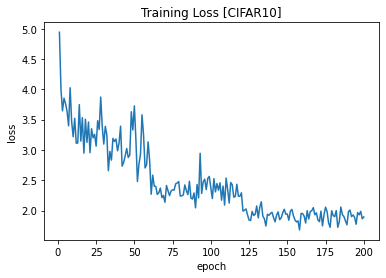

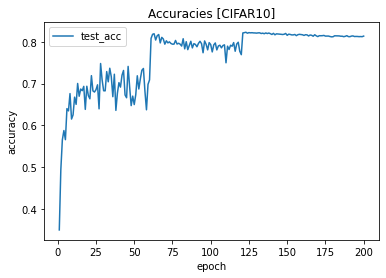

In [ ]:
knowldge_distillation(midle_net,mini_model,200)
# history_midle_to_mini

大中小へ

In [ ]:
def knowldge_distillation(T_net,gane,epoch):
    # 入力された乗数から、本当のモデルのノード数とする。
    gane=list(map(int,gane))
    print(*gane)
    model_gane=[]
    gane_number=[0,16,32,64,128,256,512]
    for i in gane:
        if gane_number[i]!=0:
            model_gane.append(gane_number[i])

    global history_large_to_midle
    
    history_large_to_midle = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    net: torch.nn.Module = CreateVGG_2(model_gane)
    net.to(device)
    T_net.to(device)

    criterion = T_S_Closs_entropy()
    
    lr_set = 0.1
    for e in range(epoch):
        if e!=0 and e%60==0:
            lr_set *= 0.2
        optimizer = torch.optim.SGD(net.parameters(), lr=lr_set,momentum=0.9, weight_decay=5e-4)
        net.train()
        loss = None

        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device) 
            labels = labels.to(device)

            optimizer.zero_grad()
            output = net(images)
            data_one = T_net(images)

            #(p, q, label, T)
            loss = criterion(output, data_one, labels, 4)
            loss.backward()
            optimizer.step()
        history_large_to_midle['train_loss'].append(loss.item())
        print('Training log: {} epoch：Loss: {}'.format(e + 1,loss.item()))

        net.eval()
        correct = 0
        with torch.no_grad():
            for images, labels in loader['test']:
                images = images.to(device) 
                labels = labels.to(device)
                #　蒸留モデルは、推論時は温度を1に戻します。
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                #torch.max(a, axis) (axis=0:col, axis=1:row)ごとに最大値を取ってくれている。
                correct += (predicted == labels).sum().item()

        acc = float(correct / (10000))
        print('test accuracy:{}'.format(acc))
        history_large_to_midle['test_acc'].append(acc)

    path = "/content/gdrive/My Drive/2020_秋_TERM/2020_12_初月/large_to_midle.pth" # 保存先pathの設定
    torch.save(net.state_dict(), path)

     # 結果をプロット
    plt.figure()
    plt.plot(range(1, epoch+1), history_large_to_midle['train_loss'])
    plt.title('Training Loss [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('cifar10_loss.png')
    
    
    plt.figure()
    plt.plot(range(1, epoch + 1), history_large_to_midle['test_acc'], label='test_acc')
    plt.title('Accuracies [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('cifar10_acc.png')

    # accとelapsedは、教師モデルの出力を受け取るようにしておきましょう。
    # return speed_acc_normalization_harmonic_mean(s_max,0,elapsed_time,a_max,0,acc)

2 2 0 0 0 1 1 0 4 5 0 0 0 3
Training log: 1 epoch：Loss: 4.1901044845581055
test accuracy:0.3855
Training log: 2 epoch：Loss: 3.5693068504333496
test accuracy:0.5885
Training log: 3 epoch：Loss: 3.7624356746673584
test accuracy:0.573
Training log: 4 epoch：Loss: 3.5062005519866943
test accuracy:0.7207
Training log: 5 epoch：Loss: 3.1750335693359375
test accuracy:0.72
Training log: 6 epoch：Loss: 3.2513630390167236
test accuracy:0.7024
Training log: 7 epoch：Loss: 3.226909637451172
test accuracy:0.7525
Training log: 8 epoch：Loss: 3.239824056625366
test accuracy:0.6208
Training log: 9 epoch：Loss: 3.034127712249756
test accuracy:0.7459
Training log: 10 epoch：Loss: 3.077500820159912
test accuracy:0.7537
Training log: 11 epoch：Loss: 3.1928606033325195
test accuracy:0.7378
Training log: 12 epoch：Loss: 3.1563684940338135
test accuracy:0.7552
Training log: 13 epoch：Loss: 2.7965221405029297
test accuracy:0.7145
Training log: 14 epoch：Loss: 3.0911948680877686
test accuracy:0.7272
Training log: 15 epoch

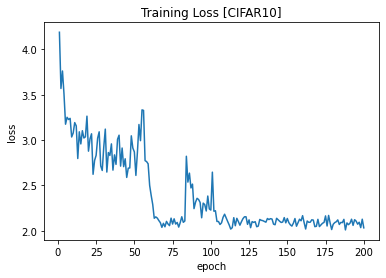

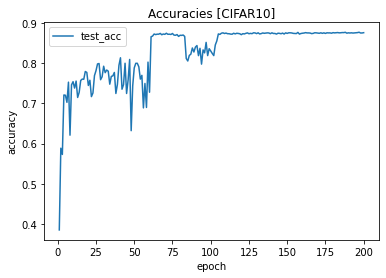

In [ ]:
knowldge_distillation(large_net,midle_model,200)
# history_large_to_midle

### **教師に向いていないと言われる、大モデル→中モデルの蒸留モデル(中)**

In [ ]:
large_to_midle_net: torch.nn.Module = CreateVGG_2(gane_convert(midle_model))
param = torch.load('/content/gdrive/My Drive/2020_秋_TERM/2020_12_初月/large_to_midle.pth')
large_to_midle_net.load_state_dict(param)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
large_to_midle_net.to(device)

[2, 2, 0, 0, 0, 1, 1, 0, 4, 5, 0, 0, 0, 3]
[32, 32, 16, 16, 128, 256, 64]


CreateVGG_2(
  (fc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc4): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc5): Sequential(
    (0): Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12

In [ ]:
def knowldge_distillation(T_net,gane,epoch):
    # 入力された乗数から、本当のモデルのノード数とする。
    gane=list(map(int,gane))
    print(*gane)
    model_gane=[]
    gane_number=[0,16,32,64,128,256,512]
    for i in gane:
        if gane_number[i]!=0:
            model_gane.append(gane_number[i])

    global history_large_to_midle_to_mini

    history_large_to_midle_to_mini = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    net: torch.nn.Module = CreateVGG_2(model_gane)
    net.to(device)
    T_net.to(device)

    criterion = T_S_Closs_entropy()
    
    lr_set = 0.1
    for e in range(epoch):
        if e!=0 and e%60==0:
            lr_set *= 0.2
        optimizer = torch.optim.SGD(net.parameters(), lr=lr_set,momentum=0.9, weight_decay=5e-4)
        net.train()
        loss = None

        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device) 
            labels = labels.to(device)

            optimizer.zero_grad()
            output = net(images)
            data_one = T_net(images)

            #(p, q, label, T)
            loss = criterion(output, data_one, labels, 4)
            loss.backward()
            optimizer.step()
        history_large_to_midle_to_mini['train_loss'].append(loss.item())
        print('Training log: {} epoch：Loss: {}'.format(e + 1,loss.item()))

        net.eval()
        correct = 0
        with torch.no_grad():
            for images, labels in loader['test']:
                images = images.to(device) 
                labels = labels.to(device)
                #　蒸留モデルは、推論時は温度を1に戻します。
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                #torch.max(a, axis) (axis=0:col, axis=1:row)ごとに最大値を取ってくれている。
                correct += (predicted == labels).sum().item()

        acc = float(correct / (10000))
        print('test accuracy:{}'.format(acc))
        history_large_to_midle_to_mini['test_acc'].append(acc)

    path = "/content/gdrive/My Drive/2020_秋_TERM/2020_12_初月/large_to_midle_to_mini.pth" # 保存先pathの設定
    torch.save(net.state_dict(), path)

     # 結果をプロット
    plt.figure()
    plt.plot(range(1, epoch+1), history_large_to_midle_to_mini['train_loss'])
    plt.title('Training Loss [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('cifar10_loss.png')
    
    
    plt.figure()
    plt.plot(range(1, epoch + 1), history_large_to_midle_to_mini['test_acc'], label='test_acc')
    plt.title('Accuracies [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('cifar10_acc.png')

    # accとelapsedは、教師モデルの出力を受け取るようにしておきましょう。
    # return speed_acc_normalization_harmonic_mean(s_max,0,elapsed_time,a_max,0,acc)

1 3 2 0 0 0 0 0 3 0 0 0 0 1
Training log: 1 epoch：Loss: 4.517003059387207
test accuracy:0.3835
Training log: 2 epoch：Loss: 4.1304168701171875
test accuracy:0.4712
Training log: 3 epoch：Loss: 3.9075136184692383
test accuracy:0.4867
Training log: 4 epoch：Loss: 4.049731254577637
test accuracy:0.5422
Training log: 5 epoch：Loss: 3.919295310974121
test accuracy:0.6166
Training log: 6 epoch：Loss: 3.921307325363159
test accuracy:0.5284
Training log: 7 epoch：Loss: 3.8482747077941895
test accuracy:0.5991
Training log: 8 epoch：Loss: 3.9437222480773926
test accuracy:0.6229
Training log: 9 epoch：Loss: 4.245911121368408
test accuracy:0.5159
Training log: 10 epoch：Loss: 3.6986682415008545
test accuracy:0.6492
Training log: 11 epoch：Loss: 3.7241735458374023
test accuracy:0.651
Training log: 12 epoch：Loss: 3.5765771865844727
test accuracy:0.6723
Training log: 13 epoch：Loss: 3.601365327835083
test accuracy:0.6792
Training log: 14 epoch：Loss: 3.3052916526794434
test accuracy:0.6913
Training log: 15 epoch

ValueError: ignored

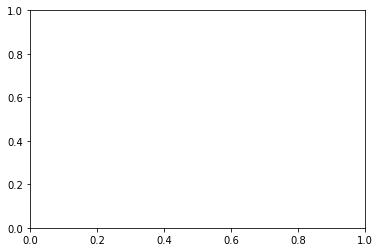

In [ ]:
knowldge_distillation(large_to_midle_net,mini_model,200)
# history_large_to_midle_to_mini

# **図式**

①小　と　中→小

論文通りなら、中→小が勝ちます。

②大→小　と　小

予想不可

③大→小　と　中→小

論文通りなら、中→小が勝ちます。

④大→中→小　と　大→小　と　中→小

論文通りなら、中→小が勝ちます。

比較したいこと一覧

①では、蒸留が有効であることを示します。

②では、教師モデルと生徒モデルのGAPが大きいとモデルが悪くなる可能性を検証する。

③では、蒸留のGAPは小さい方が精度がいい→必ずしも精度が高いものがいい教師にはならない？検証

④では、シーケンシャル知識蒸留が可能かどうか比較

⑤いい教師と悪い教師の比較をします

→大中と中、中と大の比較が一般的？

In [ ]:
epoch = 200

ハードターゲット学習と蒸留学習


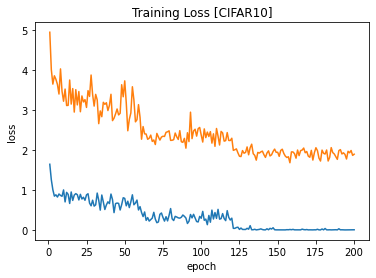

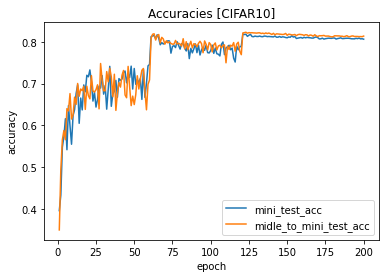

In [ ]:
print("ハードターゲット学習と蒸留学習")
plt.figure()
plt.plot(range(1, epoch+1), history_mini['train_loss'])
plt.plot(range(1, epoch+1), history_midle_to_mini['train_loss'])
plt.title('Training Loss [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('cifar10_loss.png')


plt.figure()
plt.plot(range(1, epoch + 1), history_mini['test_acc'], label='mini_test_acc')
plt.plot(range(1, epoch + 1), history_midle_to_mini['test_acc'], label='midle_to_mini_test_acc')
plt.title('Accuracies [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('cifar10_acc.png')

ハードターゲット学習とGAPのある蒸留学習


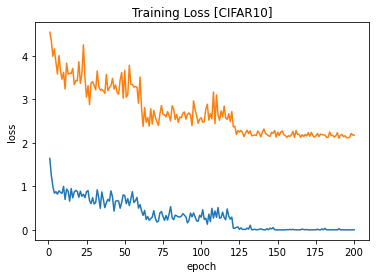

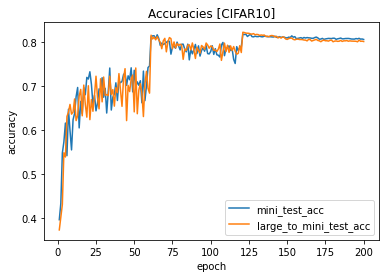

In [ ]:
print("ハードターゲット学習とGAPのある蒸留学習")
plt.figure()
plt.plot(range(1, epoch+1), history_mini['train_loss'])
plt.plot(range(1, epoch+1), history_large_to_mini['train_loss'])
plt.title('Training Loss [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('cifar10_loss.png')


plt.figure()
plt.plot(range(1, epoch + 1), history_mini['test_acc'], label='mini_test_acc')
plt.plot(range(1, epoch + 1), history_large_to_mini['test_acc'], label='large_to_mini_test_acc')
plt.title('Accuracies [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('cifar10_acc.png')

ハードターゲット学習と蒸留学習


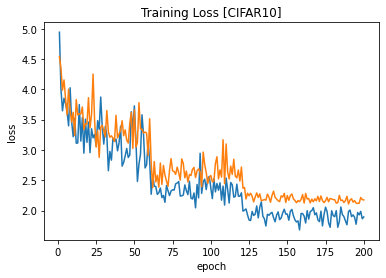

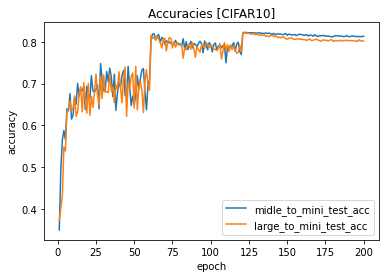

In [ ]:
print("ハードターゲット学習と蒸留学習")
plt.figure()
plt.plot(range(1, epoch+1), history_midle_to_mini['train_loss'])
plt.plot(range(1, epoch+1), history_large_to_mini['train_loss'])
plt.title('Training Loss [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('cifar10_loss.png')


plt.figure()
plt.plot(range(1, epoch + 1), history_midle_to_mini['test_acc'], label='midle_to_mini_test_acc')
plt.plot(range(1, epoch + 1), history_large_to_mini['test_acc'], label='large_to_mini_test_acc')
plt.title('Accuracies [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('cifar10_acc.png')

ハードターゲット学習と蒸留学習


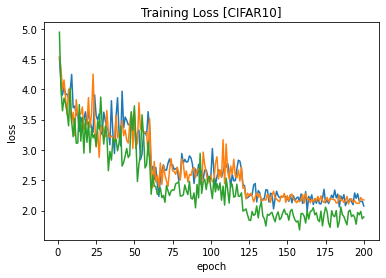

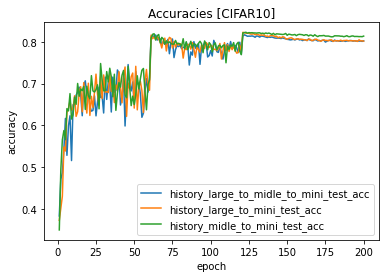

In [ ]:
print("ハードターゲット学習と蒸留学習")
plt.figure()
plt.plot(range(1, epoch+1), history_large_to_midle_to_mini['train_loss'])
plt.plot(range(1, epoch+1), history_large_to_mini['train_loss'])
plt.plot(range(1, epoch+1), history_midle_to_mini['train_loss'])
plt.title('Training Loss [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('cifar10_loss.png')


plt.figure()
plt.plot(range(1, epoch + 1), history_large_to_midle_to_mini['test_acc'], label='history_large_to_midle_to_mini_test_acc')
plt.plot(range(1, epoch + 1), history_large_to_mini['test_acc'], label='history_large_to_mini_test_acc')
plt.plot(range(1, epoch + 1), history_midle_to_mini['test_acc'], label='history_midle_to_mini_test_acc')
plt.title('Accuracies [CIFAR10]')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('cifar10_acc.png')

In [ ]:
print("終了")

終了
